## 준비 단계

In [ ]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [ ]:
!pip install ultralytics -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 757.2/757.2 kB 15.7 MB/s eta 0:00:00


In [ ]:
!wandb disabled -q

/bin/bash: line 1: wandb: command not found


In [ ]:
from google.colab import drive

# Google Drive 마운트
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

# zip 파일 경로
zip_file_path = '/content/drive/MyDrive/underwater_pollution.zip'

# zip 파일 압축 해제
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/sample_images')

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
from glob import glob
from PIL import Image

## 사전 테스트

이미지 정규화 테스트

Contrasted image saved at: /content/contrasted_image.jpg


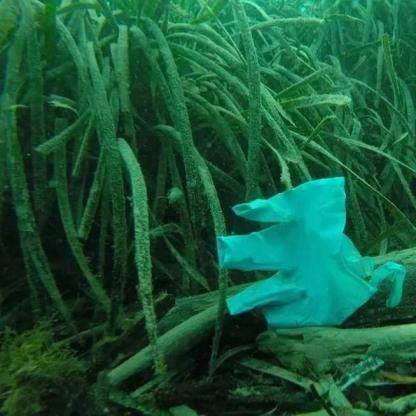

In [ ]:
# test
import cv2
from google.colab.patches import cv2_imshow

image_path = '/content/drive/MyDrive/underwater_plastics/test/images/1bc7-iudfmpmn7245599_jpg.rf.c753c3518aa3bd30463da5e4b94a48be.jpg'
image = cv2.imread(image_path)

# 밝기 조절
alpha = 0.7  # 밝기 감소 정도 (0보다 작으면 어둡게)
beta = 0  # 밝기 조절 상수
adjusted_image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

# 이미지 픽셀 값을 0과 1 사이로 정규화
normalized_image = cv2.normalize(adjusted_image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

# 저장할 경로
output_path = '/content/contrasted_image.jpg'
# 이미지 저장
cv2.imwrite(output_path, normalized_image)
print("Contrasted image saved at:", output_path)

cv2_imshow(image)


bounding box 회전 테스트

: x_center, y_center, width, height는 이미지 크기 416에 맞추어 정규화 되어 있음
: (좌상단 x, y와 우하단 x, y)으로 변경

In [ ]:
image.shape

(416, 416, 3)

In [ ]:
text_path = '/content/drive/MyDrive/underwater_plastics/test/labels/1bc7-iudfmpmn7245599_jpg.rf.c753c3518aa3bd30463da5e4b94a48be.txt'

with open(text_path, 'r') as f:
    annotations = f.readlines()
    print(annotations)
    print('-------------------------------------------------------------')

# 각 줄에 대해 객체 정보 추출하여 데이터셋 구성
for annotation in annotations:
  # 클래스 레이블과 바운딩 박스 정보 추출
  label, x_center, y_center, width, height = map(float, annotation.split())
  print(label, x_center, y_center, width, height)

['5 0.7175480769230769 0.6286057692307693 0.5180288461538461 0.36658653846153844']
-------------------------------------------------------------
5.0 0.7175480769230769 0.6286057692307693 0.5180288461538461 0.36658653846153844


In [ ]:
def rotate_bbox(cx_norm, cy_norm, w_norm, h_norm, angle):

    x_center = int(cx_norm * 416)
    y_center = int(cy_norm * 416)
    width = int(w_norm * 416)
    height = int(h_norm * 416)
    '''
    print("이미지 크기로 정규화된 위치")
    print([cx_norm, cy_norm, w_norm, h_norm])
    print("----------------------------------------------------------------")
    print("픽셀 단위로 변환한 위치")
    print([x_center, y_center, width, height])
    print("----------------------------------------------------------------")
    '''
    if angle == 0:
        return [int(x_center - width / 2), int(y_center - height / 2), int(x_center + width / 2), int(y_center + height / 2)]
    elif angle == 90:
        return [int(x_center - height / 2), int(y_center - width / 2), int(x_center + height / 2), int(y_center + width / 2)]
    elif angle == 180:
        return [int(x_center + width / 2), int(y_center + height / 2), int(x_center - width / 2), int(y_center - height / 2)]
    elif angle == 270:
        return [int(x_center + height / 2), int(y_center + width / 2), int(x_center - height / 2), int(y_center - width / 2)]
    else:
        raise ValueError("Invalid angle. Angle must be 90, 180, or 270.")

In [ ]:
rotate_bbox(x_center, y_center, width, height, 90)

[222, 153, 374, 368]

## 전처리 실행

- 명암, 색감, 선명도, 픽셀정규화 진행

- 0, 90, 180, 270 회전하여 데이터를 4배로 증가
  - -> 회전에 따른 bounding box 설정(함수 rotate_bbox)
  - 각도에 따라 이미지 파일 이름에 "rotate(각도)_"를 앞단에 추가하였음

In [ ]:
import cv2
import os

for data in ['train','valid','test']:

  # 이미지가 저장된 폴더 경로
  images_folder = f'/content/sample_images/underwater_plastics/{data}/images'
  # 새로운 이미지를 저장할 폴더 경로
  augmented_folder = f'/content/drive/MyDrive/preprocessed_data/{data}/images'

  # 새로운 폴더 생성
  os.makedirs(augmented_folder, exist_ok=True)

  # 이미지 파일 목록 가져오기
  image_files = os.listdir(images_folder)

  # augmentation 수행
  for image_file in image_files:
      # 이미지 불러오기
      image_path = os.path.join(images_folder, image_file)
      image = cv2.imread(image_path)

      # 명암 조절
      alpha = 0.7  # 명암 조절 정도, 1보다 크면 밝게, 작으면 어둡게
      beta = -20  # 밝기 조절 정도
      adjusted_image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

      # 파란끼를 줄이기 위해 BGR에서 LAB 색 공간으로 변환
      lab_image = cv2.cvtColor(adjusted_image, cv2.COLOR_BGR2LAB)
      # LAB 색 공간에서 각 채널 분리
      l, a, b = cv2.split(lab_image)
      a = cv2.add(a, 10)
      b = cv2.add(b, -10)
      adjusted_lab_image = cv2.merge([l, a, b])
      # LAB에서 다시 BGR로 변환
      color_adjusted_image = cv2.cvtColor(adjusted_lab_image, cv2.COLOR_LAB2BGR)


      # 선명도 조정 (양방향 필터링)
      total_adjusted_image = cv2.bilateralFilter(color_adjusted_image, 9, 75, 75)

      # 회전1
      angle = 0  # 회전 각도
      rows, cols = total_adjusted_image.shape[:2]
      rotation_matrix = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
      rotated_image1 = cv2.warpAffine(total_adjusted_image, rotation_matrix, (cols, rows))

      # 회전2
      angle = 90  # 회전 각도
      rows, cols = total_adjusted_image.shape[:2]
      rotation_matrix = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
      rotated_image2 = cv2.warpAffine(total_adjusted_image, rotation_matrix, (cols, rows))

      # 회전3
      angle = 180  # 회전 각도
      rows, cols = total_adjusted_image.shape[:2]
      rotation_matrix = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
      rotated_image3 = cv2.warpAffine(total_adjusted_image, rotation_matrix, (cols, rows))

      # 회전4
      angle = 270  # 회전 각도
      rows, cols = total_adjusted_image.shape[:2]
      rotation_matrix = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
      rotated_image4 = cv2.warpAffine(total_adjusted_image, rotation_matrix, (cols, rows))

      # 이미지 픽셀 값을 0과 255 사이로 정규화
      normalized_image1 = cv2.normalize(rotated_image1, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
      normalized_image2 = cv2.normalize(rotated_image2, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
      normalized_image3 = cv2.normalize(rotated_image3, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
      normalized_image4 = cv2.normalize(rotated_image4, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

      normalized_images = [normalized_image1, normalized_image2, normalized_image3, normalized_image4]

      # augmentation된 이미지 저장
      for i in range(4):
        new_image_file = os.path.join(augmented_folder, f"rotate{i*90}_{image_file}")
        cv2.imwrite(new_image_file, normalized_images[i])


print("Augmentation 완료")


KeyboardInterrupt: 

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import os
import json


excluded_paths = [
    'uwg_g-1273_jpg.rf.62a8833f29759fc0122e8263c38a5a4a.txt',
    'uwg_g-1293_jpg.rf.3741076eb1220c77efe9427f2c13386c.txt',
    'gloves_in_the_ocean2_jpg.rf.45557ebd23757870bf38302fd19c0454.txt',
    'mask_in_the_ocean_39_jpg.rf.c61ba35d9450c0dc0483dc3bee4bb188.txt',
    'uwg_g-151_jpg.rf.9c77a9068d8a9364594fe78ec1d907df.txt',
    'uwg_g-838__flipv_jpg.rf.4cb0a5ecfe2561ad5979ba148a56b6b4.txt'
]

for data in ['train','valid','test']:
  num = 0

  globals()[f'dataset_{data}'] = {}

  # 텍스트 파일이 저장된 폴더 경로
  text_folder = f'/content/sample_images/underwater_plastics/{data}/labels'

  # 텍스트 파일 목록 가져오기
  text_files = os.listdir(text_folder)
  keys = []
  images = []
  texts = []
  labels = []
  bboxes = []

  for text_file in text_files:

    if text_file in excluded_paths:
      continue

    # 텍스트 파일 경로
    text_file_path = os.path.join(text_folder, text_file)



    # 텍스트 파일 읽기
    with open(text_file_path, 'r') as f:
      annotations = f.readlines()

    num += 1
    for i in range(4):
      label_list = []
      bbox_list = []

      # 이미지 파일 이름을 키로 사용하여 데이터셋에 추가
      image_name = f"rotate{i*90}_"+text_file.replace('.txt', '.jpg')
      keys.append(f'{data}_rotate{i*90}_{num}') # 마지막 4개 문자열'.txt'를 제거한 파일 이름: 뒤에 jpg가 붙으면 해당 이미지 파일 이름임

      image_file_path = f'/content/drive/MyDrive/preprocessed_data/{data}/images/{image_name}'
      # image = cv2.imread(image_path)
      # 이미지를 tensor형태로 json에 저장하는 것은 json파일이 너무 커져서 권장하지 않는다고 하네요.
      # 이미지의 경로를 저장하겠습니다
      images.append(image_file_path)
      texts.append(text_file_path)

      # 각 줄에 대해 객체 정보 추출하여 데이터셋 구성
      for annotation in annotations:
        # 클래스 레이블과 바운딩 박스 정보 추출
        label, x_center, y_center, width, height = map(float, annotation.split())
        bbox = rotate_bbox(x_center, y_center, width, height,i*90)  # 좌표변환 함수는 위의 셀에 있어용
        label_list.append(label)
        bbox_list.append(bbox)

      labels.append(label_list)
      bboxes.append(bbox_list)

  # 길이확인 -> 원래 데이터의 4배가 되어야 함(90,180,270 회전 이슈)
  print(len(keys))
  print(len(images))
  print(len(texts))
  print(len(bboxes))
  print(len(labels))

  # Convert non-serializable values to serializable format
  for i in range(len(keys)):

    globals()[f'dataset_{data}'][keys[i]] = {
          'image': images[i],
          'text': texts[i],
          'bbox': bboxes[i],
          'label': labels[i]
      }

  # Write dictionary to a JSON file
  with open(f'/content/drive/MyDrive/preprocessed_data/dataset_{data}.json', 'w') as json_file:
      json.dump(globals()[f'dataset_{data}'], json_file, indent=4)    # indent는 들여쓰기 칸

14512
14512
14512
14512
14512
4004
4004
4004
4004
4004
2004
2004
2004
2004
2004


- dataset에서 key의 값은 다음과 같은 형식을 가진다.

- {데이터 유형}\_{회전각도}\_{원시 데이터 순서}
- ex) train_rotate0_1


In [ ]:
dataset_train

{'train_rotate0_1': {'image': '/content/drive/MyDrive/preprocessed_data/train/images/rotate0_uwg_g-356_jpeg_jpg.rf.1ebcb3715d520d8e6ed6108379643f1b.jpg',
  'text': '/content/sample_images/underwater_plastics/train/labels/uwg_g-356_jpeg_jpg.rf.1ebcb3715d520d8e6ed6108379643f1b.txt',
  'bbox': [[187, 130, 242, 311]],
  'label': [2.0]},
 'train_rotate90_1': {'image': '/content/drive/MyDrive/preprocessed_data/train/images/rotate90_uwg_g-356_jpeg_jpg.rf.1ebcb3715d520d8e6ed6108379643f1b.jpg',
  'text': '/content/sample_images/underwater_plastics/train/labels/uwg_g-356_jpeg_jpg.rf.1ebcb3715d520d8e6ed6108379643f1b.txt',
  'bbox': [[124, 193, 305, 248]],
  'label': [2.0]},
 'train_rotate180_1': {'image': '/content/drive/MyDrive/preprocessed_data/train/images/rotate180_uwg_g-356_jpeg_jpg.rf.1ebcb3715d520d8e6ed6108379643f1b.jpg',
  'text': '/content/sample_images/underwater_plastics/train/labels/uwg_g-356_jpeg_jpg.rf.1ebcb3715d520d8e6ed6108379643f1b.txt',
  'bbox': [[242, 311, 187, 130]],
  'label

In [ ]:
dataset_valid

{'valid_rotate0_1': {'image': '/content/drive/MyDrive/preprocessed_data/valid/images/rotate0_uwg_yt-218__flipv_png_jpg.rf.cffbc81a0eb7f9c0d33edcb8c71b1ddf.jpg',
  'text': '/content/sample_images/underwater_plastics/valid/labels/uwg_yt-218__flipv_png_jpg.rf.cffbc81a0eb7f9c0d33edcb8c71b1ddf.txt',
  'bbox': [[123, 24, 282, 409]],
  'label': [4.0]},
 'valid_rotate90_1': {'image': '/content/drive/MyDrive/preprocessed_data/valid/images/rotate90_uwg_yt-218__flipv_png_jpg.rf.cffbc81a0eb7f9c0d33edcb8c71b1ddf.jpg',
  'text': '/content/sample_images/underwater_plastics/valid/labels/uwg_yt-218__flipv_png_jpg.rf.cffbc81a0eb7f9c0d33edcb8c71b1ddf.txt',
  'bbox': [[10, 137, 395, 296]],
  'label': [4.0]},
 'valid_rotate180_1': {'image': '/content/drive/MyDrive/preprocessed_data/valid/images/rotate180_uwg_yt-218__flipv_png_jpg.rf.cffbc81a0eb7f9c0d33edcb8c71b1ddf.jpg',
  'text': '/content/sample_images/underwater_plastics/valid/labels/uwg_yt-218__flipv_png_jpg.rf.cffbc81a0eb7f9c0d33edcb8c71b1ddf.txt',
  

In [ ]:
dataset_test

{'test_rotate0_1': {'image': '/content/drive/MyDrive/preprocessed_data/test/images/rotate0_uwg_g-906__flipv_jpg.rf.041dfb90c7ba883e8d7196ad110bcfdd.jpg',
  'text': '/content/sample_images/underwater_plastics/test/labels/uwg_g-906__flipv_jpg.rf.041dfb90c7ba883e8d7196ad110bcfdd.txt',
  'bbox': [[157, 132, 253, 323]],
  'label': [9.0]},
 'test_rotate90_1': {'image': '/content/drive/MyDrive/preprocessed_data/test/images/rotate90_uwg_g-906__flipv_jpg.rf.041dfb90c7ba883e8d7196ad110bcfdd.jpg',
  'text': '/content/sample_images/underwater_plastics/test/labels/uwg_g-906__flipv_jpg.rf.041dfb90c7ba883e8d7196ad110bcfdd.txt',
  'bbox': [[109, 180, 300, 276]],
  'label': [9.0]},
 'test_rotate180_1': {'image': '/content/drive/MyDrive/preprocessed_data/test/images/rotate180_uwg_g-906__flipv_jpg.rf.041dfb90c7ba883e8d7196ad110bcfdd.jpg',
  'text': '/content/sample_images/underwater_plastics/test/labels/uwg_g-906__flipv_jpg.rf.041dfb90c7ba883e8d7196ad110bcfdd.txt',
  'bbox': [[253, 323, 157, 132]],
  'la

In [ ]:
len(dataset_valid)

4004

끝